In [1]:
%matplotlib inline

## Setup GPU Device

In [2]:
import random
import os
import matplotlib.pyplot as plt
import networkx as nx
import csv
import numpy as np

import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.nn import GCNConv,GATConv
from gnnexplainer import GNNExplainer



def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

        
def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')
    
class PYGNet(torch.nn.Module):
    def __init__(self,in_dim, hidden_dim, n_classes):
        super(PYGNet, self).__init__()
#         self.lin = Sequential(Linear(10, 10))
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
#         x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = torch.mean(x, 0, True)
        return self.classify(x)
    
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)
#Remove redundant edges from edge list based on sampled node list
def remove_edges(node_list,edge_list):
    
    edge_list_keep = []
    for i in edge_list:
        cnt=0
        for j in i:
            if [j] in node_list:
                cnt=cnt+1
            if cnt==2:
                edge_list_keep.append(i)
                
    return edge_list_keep

#Map edge_list_keep to new node labels
def map_edge_list_keep(edge_list_keep,node_list_keep):
    
    edge_list_keep_mapped = []
    for i in edge_list_keep:
        edge_list_keep_mapped.append([node_list_keep.index([i[0]]),node_list_keep.index([i[1]])])

    return edge_list_keep_mapped

Using backend: pytorch


In [3]:
import os
#Set GPU IDs for training:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [4]:

def build_circuit_graph_undirected(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    g.add_edges(dst, src)
    return g

def build_circuit_graph_directed_sd(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    return g

def build_circuit_graph_directed_ds(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(dst, src)
    return g


### Choose Number of Training Samples

### Train Test Split

In [5]:
random.seed(1) #original=0
training_size = 10
training_idx = random.sample(list(range(5,65)), training_size) #exclude 4-bit adders
test_idx = [item for item in list(range(5,65)) if item not in training_idx]

In [6]:
training_idx

[13, 41, 59, 56, 53, 9, 21, 12, 36, 60]

In [7]:
len(training_idx),len(test_idx)

(10, 50)

## Pick Training Data

In [8]:

dir = '/home/gpu-user-02/hdd/LT-user/Adder_Classification/main/preprocessing/processed_training_data'

trainset=[]
labels=[]
#for filename in os.listdir(dir):
np.random.seed(0) #original=1
sample_size = 10
# training_idx = np.random.randint(4,64,10)
training_idx_1 = np.random.choice(training_idx, size=sample_size, replace=False)
# training_idx_2 = np.random.choice(training_idx, size=sample_size, replace=False)
# training_idx_3 = np.random.choice(training_idx, size=sample_size, replace=False)
# training_idx_4 = np.random.choice(training_idx, size=sample_size, replace=False)

training_idx_2 = training_idx_1
training_idx_3 = training_idx_1
training_idx_4 = training_idx_1
# training_idx_1 = [6]
# training_idx_2 = [6]
# training_idx_3 = [6]
# training_idx_4 = [6]
print(training_idx_1,training_idx_2,training_idx_3,training_idx_4)

[59 36 53 60 41 21 12 56 13  9] [59 36 53 60 41 21 12 56 13  9] [59 36 53 60 41 21 12 56 13  9] [59 36 53 60 41 21 12 56 13  9]


### Prepare Training and Test Data

In [9]:
for idx in range(len(training_idx_1)):
    node_list=[]
    edge_list=[]
    label_list=[]
    node_list2=[]
    edge_list2=[]
    label_list2=[]
    node_list3=[]
    edge_list3=[]
    label_list3=[]
    node_list4=[]
    edge_list4=[]
    label_list4=[]
    for j in ["node_list","edge_list","graph_label"]:
        filename = "rca_"+str(training_idx_1[idx])+"bit"+j+'.csv'
        filename2 = "cla_"+str(training_idx_2[idx])+"bit"+j+'.csv'
        filename3 = "csa_"+str(training_idx_3[idx])+"bit"+j+'.csv'
        filename4 = "CSkipA_"+str(training_idx_4[idx])+"bit"+j+'.csv'
        if(filename.find("node_list")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                node_list = list(reader)
                
        if(filename.find("edge_list")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list = list(reader)
        if(filename.find("graph_label")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                label_list = list(reader)
        if(filename.find("gate_type")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type = list(reader)
        
        if(filename2.find("node_list")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                node_list2 = list(reader)
                
        if(filename2.find("edge_list")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list2 = list(reader)
        if(filename2.find("graph_label")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                label_list2 = list(reader)
        if(filename2.find("gate_type")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type2 = list(reader)
        
        if(filename3.find("node_list")>=0):
            with open(dir+'/'+filename3, 'rt') as fh:
                reader=csv.reader(fh)
                node_list3 = list(reader)
                
        if(filename3.find("edge_list")>=0):
            with open(dir+'/'+filename3, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list3 = list(reader)
        if(filename3.find("graph_label")>=0):
            with open(dir+'/'+filename3, 'rt') as fh:
                reader=csv.reader(fh)
                label_list3 = list(reader)
        if(filename3.find("gate_type")>=0):
            with open(dir+'/'+filename3, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type3 = list(reader)
        if(filename4.find("node_list")>=0):
            with open(dir+'/'+filename4, 'rt') as fh:
                reader=csv.reader(fh)
                node_list4 = list(reader)
                
        if(filename4.find("edge_list")>=0):
            with open(dir+'/'+filename4, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list4 = list(reader)
        if(filename4.find("graph_label")>=0):
            with open(dir+'/'+filename4, 'rt') as fh:
                reader=csv.reader(fh)
                label_list4 = list(reader)
        if(filename4.find("gate_type")>=0):
            with open(dir+'/'+filename4, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type4 = list(reader)
    #create dgl graph
    g=build_circuit_graph_undirected(node_list,edge_list)
    trainset.append(g)
    labels.append(label_list[0])
    g2=build_circuit_graph_undirected(node_list2,edge_list2)
    trainset.append(g2)
    labels.append(label_list2[0])
    g3=build_circuit_graph_undirected(node_list3,edge_list3)
    trainset.append(g3)
    labels.append(label_list3[0])
    g4=build_circuit_graph_undirected(node_list4,edge_list4)
    trainset.append(g4)
    labels.append(label_list4[0])

for i in labels:
    i[0] = int(i[0])

print(labels)

[[1], [0], [2], [3], [1], [0], [2], [3], [1], [0], [2], [3], [1], [0], [2], [3], [1], [0], [2], [3], [1], [0], [2], [3], [1], [0], [2], [3], [1], [0], [2], [3], [1], [0], [2], [3], [1], [0], [2], [3]]


### Visualize Training Data

In [10]:
# graph = trainset[14]
# label=labels[14][0]

# fig, ax = plt.subplots()
# G=graph.to_networkx()
# pos=nx.spring_layout(G)
# nx.draw(G,pos)
# nx.draw_networkx_labels(G,pos, ax=ax)
# ax.set_title('Class: {:f}'.format(label))
# plt.show()

### Apply random shuffle to training set

In [50]:
##apply random shuffle on the trainset
np.random.seed(0)
randomize = np.arange(len(trainset))
np.random.shuffle(randomize)
labels_shuffled=[]
trainset_shuffled=[]
for i in range (len(randomize)):
    labels_shuffled.append(labels[randomize[i]])
    trainset_shuffled.append(trainset[randomize[i]])

In [51]:
len(trainset_shuffled)

40

In [52]:


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

### Setup and training

### Make Training Results Deterministic

## Set Training Epoch

In [53]:
training_epoch = 200 #original = 1500 for 1 training sample 500 for 20 samples
initial_lr = 0.001

In [54]:
# Create model
#model = Classifier(1, 256, trainset.num_classes)
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PYGNet(1, 256, 4).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = initial_lr)
# optimizer = optim.SGD(model.parameters(), lr = initial_lr, momentum=0.9, weight_decay=5e-4)

model.train()

labels_shuffled = torch.LongTensor(labels_shuffled).to(device)

epoch_losses = []

#start timer:
t0 = time.time()

for epoch in range(training_epoch):
    model.train()
    epoch_loss = 0
    for iter, bg in enumerate(trainset_shuffled):
        x = bg.in_degrees().view(-1, 1).float().to(device)
        a = bg.edges()[0].tolist()
        b = bg.edges()[1].tolist()
        edges = list(zip(a,b))
        edges = np.array(edges)
        edges = torch.LongTensor(edges.transpose()).to(device)
        
#         prediction=torch.zeros(1,4,dtype=torch.float64)
        prediction = model(x,edges)

        loss = loss_func(prediction, labels_shuffled[iter])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

training_time = time.time() - t0

print('Finished training. Training time = {:.4f} Seconds'.format(training_time))


Epoch 0, loss 1.4393
Epoch 1, loss 1.4112
Epoch 2, loss 1.4081
Epoch 3, loss 1.4072
Epoch 4, loss 1.4035
Epoch 5, loss 1.4002
Epoch 6, loss 1.3985
Epoch 7, loss 1.3974
Epoch 8, loss 1.3955
Epoch 9, loss 1.3940
Epoch 10, loss 1.3921
Epoch 11, loss 1.3931
Epoch 12, loss 1.3905
Epoch 13, loss 1.3922
Epoch 14, loss 1.3862
Epoch 15, loss 1.3876
Epoch 16, loss 1.3840
Epoch 17, loss 1.3807
Epoch 18, loss 1.3792
Epoch 19, loss 1.3763
Epoch 20, loss 1.3731
Epoch 21, loss 1.3684
Epoch 22, loss 1.3665
Epoch 23, loss 1.3600
Epoch 24, loss 1.3541
Epoch 25, loss 1.3467
Epoch 26, loss 1.3356
Epoch 27, loss 1.3227
Epoch 28, loss 1.3122
Epoch 29, loss 1.2938
Epoch 30, loss 1.2831
Epoch 31, loss 1.2694
Epoch 32, loss 1.2498
Epoch 33, loss 1.2339
Epoch 34, loss 1.2157
Epoch 35, loss 1.1977
Epoch 36, loss 1.1808
Epoch 37, loss 1.1637
Epoch 38, loss 1.1463
Epoch 39, loss 1.1306
Epoch 40, loss 1.1141
Epoch 41, loss 1.0995
Epoch 42, loss 1.0847
Epoch 43, loss 1.0706
Epoch 44, loss 1.0569
Epoch 45, loss 1.044

### Finish Training

### Plot Loss

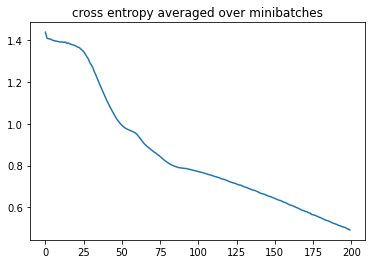

In [55]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

### Load Test data

In [56]:
testset = []
test_labels = []
test_dir = dir
pct_keep=1

testing_idx_1=[]
testing_idx_2=[]
testing_idx_3=[]
testing_idx_4=[]
for i in test_idx:
    testing_idx_1.append(i)
    testing_idx_2.append(i)
    testing_idx_3.append(i)
    testing_idx_4.append(i)
# random.seed(0)
for idx in range(len(testing_idx_1)):
    node_list=[]
    edge_list=[]
    label_list=[]
    node_list2=[]
    edge_list2=[]
    label_list2=[]
    node_list3=[]
    edge_list3=[]
    label_list3=[]
    node_list4=[]
    edge_list4=[]
    label_list4=[]
    for j in ["node_list","edge_list","graph_label"]:
        filename = "rca_"+str(testing_idx_1[idx])+"bit"+j+'.csv'
        filename2 = "cla_"+str(testing_idx_2[idx])+"bit"+j+'.csv'
        filename3 = "csa_"+str(testing_idx_3[idx])+"bit"+j+'.csv'
        filename4 = "CSkipA_"+str(testing_idx_4[idx])+"bit"+j+'.csv'
        
        if(filename.find("node_list")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                node_list = list(reader)
                
        if(filename.find("edge_list")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list = list(reader)
        if(filename.find("graph_label")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                label_list = list(reader)
        if(filename.find("gate_type")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type = list(reader)
        
        if(filename2.find("node_list")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                node_list2 = list(reader)
                
        if(filename2.find("edge_list")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list2 = list(reader)
        if(filename2.find("graph_label")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                label_list2 = list(reader)
        if(filename2.find("gate_type")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type2 = list(reader)
        if(filename3.find("node_list")>=0):
            with open(test_dir+'/'+filename3, 'rt') as fh:
                reader=csv.reader(fh)
                node_list3 = list(reader)
                
        if(filename3.find("edge_list")>=0):
            with open(test_dir+'/'+filename3, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list3 = list(reader)
        if(filename3.find("graph_label")>=0):
            with open(test_dir+'/'+filename3, 'rt') as fh:
                reader=csv.reader(fh)
                label_list3 = list(reader)
        if(filename3.find("gate_type")>=0):
            with open(test_dir+'/'+filename3, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type3 = list(reader)
        if(filename4.find("node_list")>=0):
            with open(dir+'/'+filename4, 'rt') as fh:
                reader=csv.reader(fh)
                node_list4 = list(reader)
                
        if(filename4.find("edge_list")>=0):
            with open(dir+'/'+filename4, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list4 = list(reader)
        if(filename4.find("graph_label")>=0):
            with open(dir+'/'+filename4, 'rt') as fh:
                reader=csv.reader(fh)
                label_list4 = list(reader)
        if(filename4.find("gate_type")>=0):
            with open(dir+'/'+filename4, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type4 = list(reader)
    
    #randomly sample nodes and edges from a list
    
    #Sample nodes, remove edges accordingly:
    seed = 1
    random.seed(seed)
    node_list_keep = random.sample(node_list,int(len(node_list)*pct_keep))
    edge_list_keep = remove_edges(node_list_keep,edge_list)
    edge_list_keep = map_edge_list_keep(edge_list_keep,node_list_keep)
#     node_list_keep = node_list
#     edge_list_keep = random.sample(edge_list,int(len(edge_list)*pct_keep))
    random.seed(seed)
    node_list2_keep = random.sample(node_list2,int(len(node_list2)*pct_keep))
    edge_list2_keep = remove_edges(node_list2_keep,edge_list2)
    edge_list2_keep = map_edge_list_keep(edge_list2_keep,node_list2_keep)
#     node_list2_keep = node_list2
#     edge_list2_keep = random.sample(edge_list2,int(len(edge_list2)*pct_keep))
    random.seed(seed)
    node_list3_keep = random.sample(node_list3,int(len(node_list3)*pct_keep))
    edge_list3_keep = remove_edges(node_list3_keep,edge_list3)
    edge_list3_keep = map_edge_list_keep(edge_list3_keep,node_list3_keep)
#     node_list3_keep = node_list3
#     edge_list3_keep = random.sample(edge_list3,int(len(edge_list3)*pct_keep))
    random.seed(seed)
    node_list4_keep = random.sample(node_list4,int(len(node_list4)*pct_keep))
    edge_list4_keep = remove_edges(node_list4_keep,edge_list4)
    edge_list4_keep = map_edge_list_keep(edge_list4_keep,node_list4_keep)
#     node_list4_keep = node_list4
#     edge_list4_keep = random.sample(edge_list4,int(len(edge_list4)*pct_keep))
    
    #create dgl graph
    g=build_circuit_graph_undirected(node_list_keep,edge_list_keep)
    testset.append(g)
    test_labels.append(label_list[0])
    g2=build_circuit_graph_undirected(node_list2_keep,edge_list2_keep)
    testset.append(g2)
    test_labels.append(label_list2[0])
    g3=build_circuit_graph_undirected(node_list3_keep,edge_list3_keep)
    testset.append(g3)
    test_labels.append(label_list3[0])
    g4=build_circuit_graph_undirected(node_list4_keep,edge_list4_keep)
    testset.append(g4)
    test_labels.append(label_list4[0])

for i in test_labels:
    i[0] = int(i[0])

test_labels = torch.tensor(test_labels).float().view(-1, 1).cuda()
# print(test_labels)

In [57]:
model.eval()

prediction=torch.zeros(len(testset),4,dtype=torch.float64)
for iter, bg in enumerate(testset):
        x = bg.in_degrees().view(-1, 1).float().to(device)
        a = bg.edges()[0].tolist()
        b = bg.edges()[1].tolist()
        edges = list(zip(a,b))
        edges = np.array(edges)
        edges = torch.LongTensor(edges.transpose()).to(device)
        
        
        prediction[iter] = model(x,edges)
    

In [58]:
probs_Y = torch.softmax(prediction, 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
test_labels.cuda() == sampled_Y.cuda()
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_labels.cuda() == sampled_Y.cuda().float()).sum().item() / len(test_labels.cuda()) * 100))
print('Accuracy of argmax predictions on the test set: {:.4f}%'.format(
    (test_labels.cuda() == argmax_Y.cuda().float()).sum().item() / len(test_labels.cuda()) * 100))

Accuracy of sampled predictions on the test set: 63.0000%
Accuracy of argmax predictions on the test set: 84.5000%


TypeError: forward() missing 1 required positional argument: 'edge_index'

### GNNExplainer

In [59]:
## model.eval()
x = test_g.in_degrees().view(-1, 1).float()
# x = feature
a = test_g.edges()[0].tolist()
b = test_g.edges()[1].tolist()
edges= list(zip(a,b))
edges=np.array(edges)
edges=torch.LongTensor(edges.transpose())
probs_Y = model(x, edges)

explainer = GNNExplainer(model, epochs=200)
node_idx = 366
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edges)


plt = explainer.visualize_subgraph(node_idx, edge_index=edges, edge_mask=edge_mask, y=label_tensor,threshold=None)
plt.show()

NameError: name 'test_g' is not defined

In [56]:
h.size()

torch.Size([773, 1])

## Visualize Activations

In [59]:
error = []
probs_Y2_error = []

for i in range(len(testset)):
    out = model(testset[i])
    probs_Y2 = torch.softmax(out,0)
    argmax_Y2 = torch.max(probs_Y2, 0)[1].view(-1, 1)
    if  test_labels[i]!=argmax_Y2.float():
        error.append(i)
        probs_Y2_error.append(probs_Y2)

NameError: name 'testset' is not defined

In [60]:
print('Number of Errors: {}'.format(len(error)))

Number of Errors: 0


In [66]:
# GCN1_act[0].size(),GCN2_act[0].size(),graph_emb[0].size(),final_class[0]

## End